Gas turbine engine are extensively used to generate electricity. In recent years to reduce the greenhouse gas and other harmful emissions gas turbine engines are controlled within a certain limit to safeguard the environment. 

The dataset contain the following columns:

1. AT = Ambient Temperature 
2. AP = Ambient Pressure 
3. AH = Ambient Humidity
4. AFDP = Air Filter Difference Pressure 
5. GTEP = Gas Turbine Exhaust Pressue 
6. TIT = Turbine Inlet Temperature 
7. TAT = Turbine After Temperature 
8. TEY = Turbine Energy Yield 
9. CDP = Compressor Discharge Pressure
10. CO = Carbon Monoxide 
11. NOX = Nitrogen Oxides

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

#from tensorflow.keras import layers
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from collections import defaultdict

In [58]:
turbine_data = pd.read_csv('ML_asstes\gas_turbine_data.csv', index_col=0)

turbine_data.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
1  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
2  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
3  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
4  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
5  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  
1  0.32663  81.952  
2  0.44784  82.377  
3  0.45144  83.776  
4  0.23107  82.505  
5  0.26747  82.028

In [59]:
turbine_data.describe()

AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX  
count  36733.000000  
mean      65.293067  
std       11.678357  
min       25.905000  
25%       57.162000  
50%       63.849000  
75%       71.548000  
max      119.910000

In [60]:
turbine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36733 entries, 1 to 36733
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


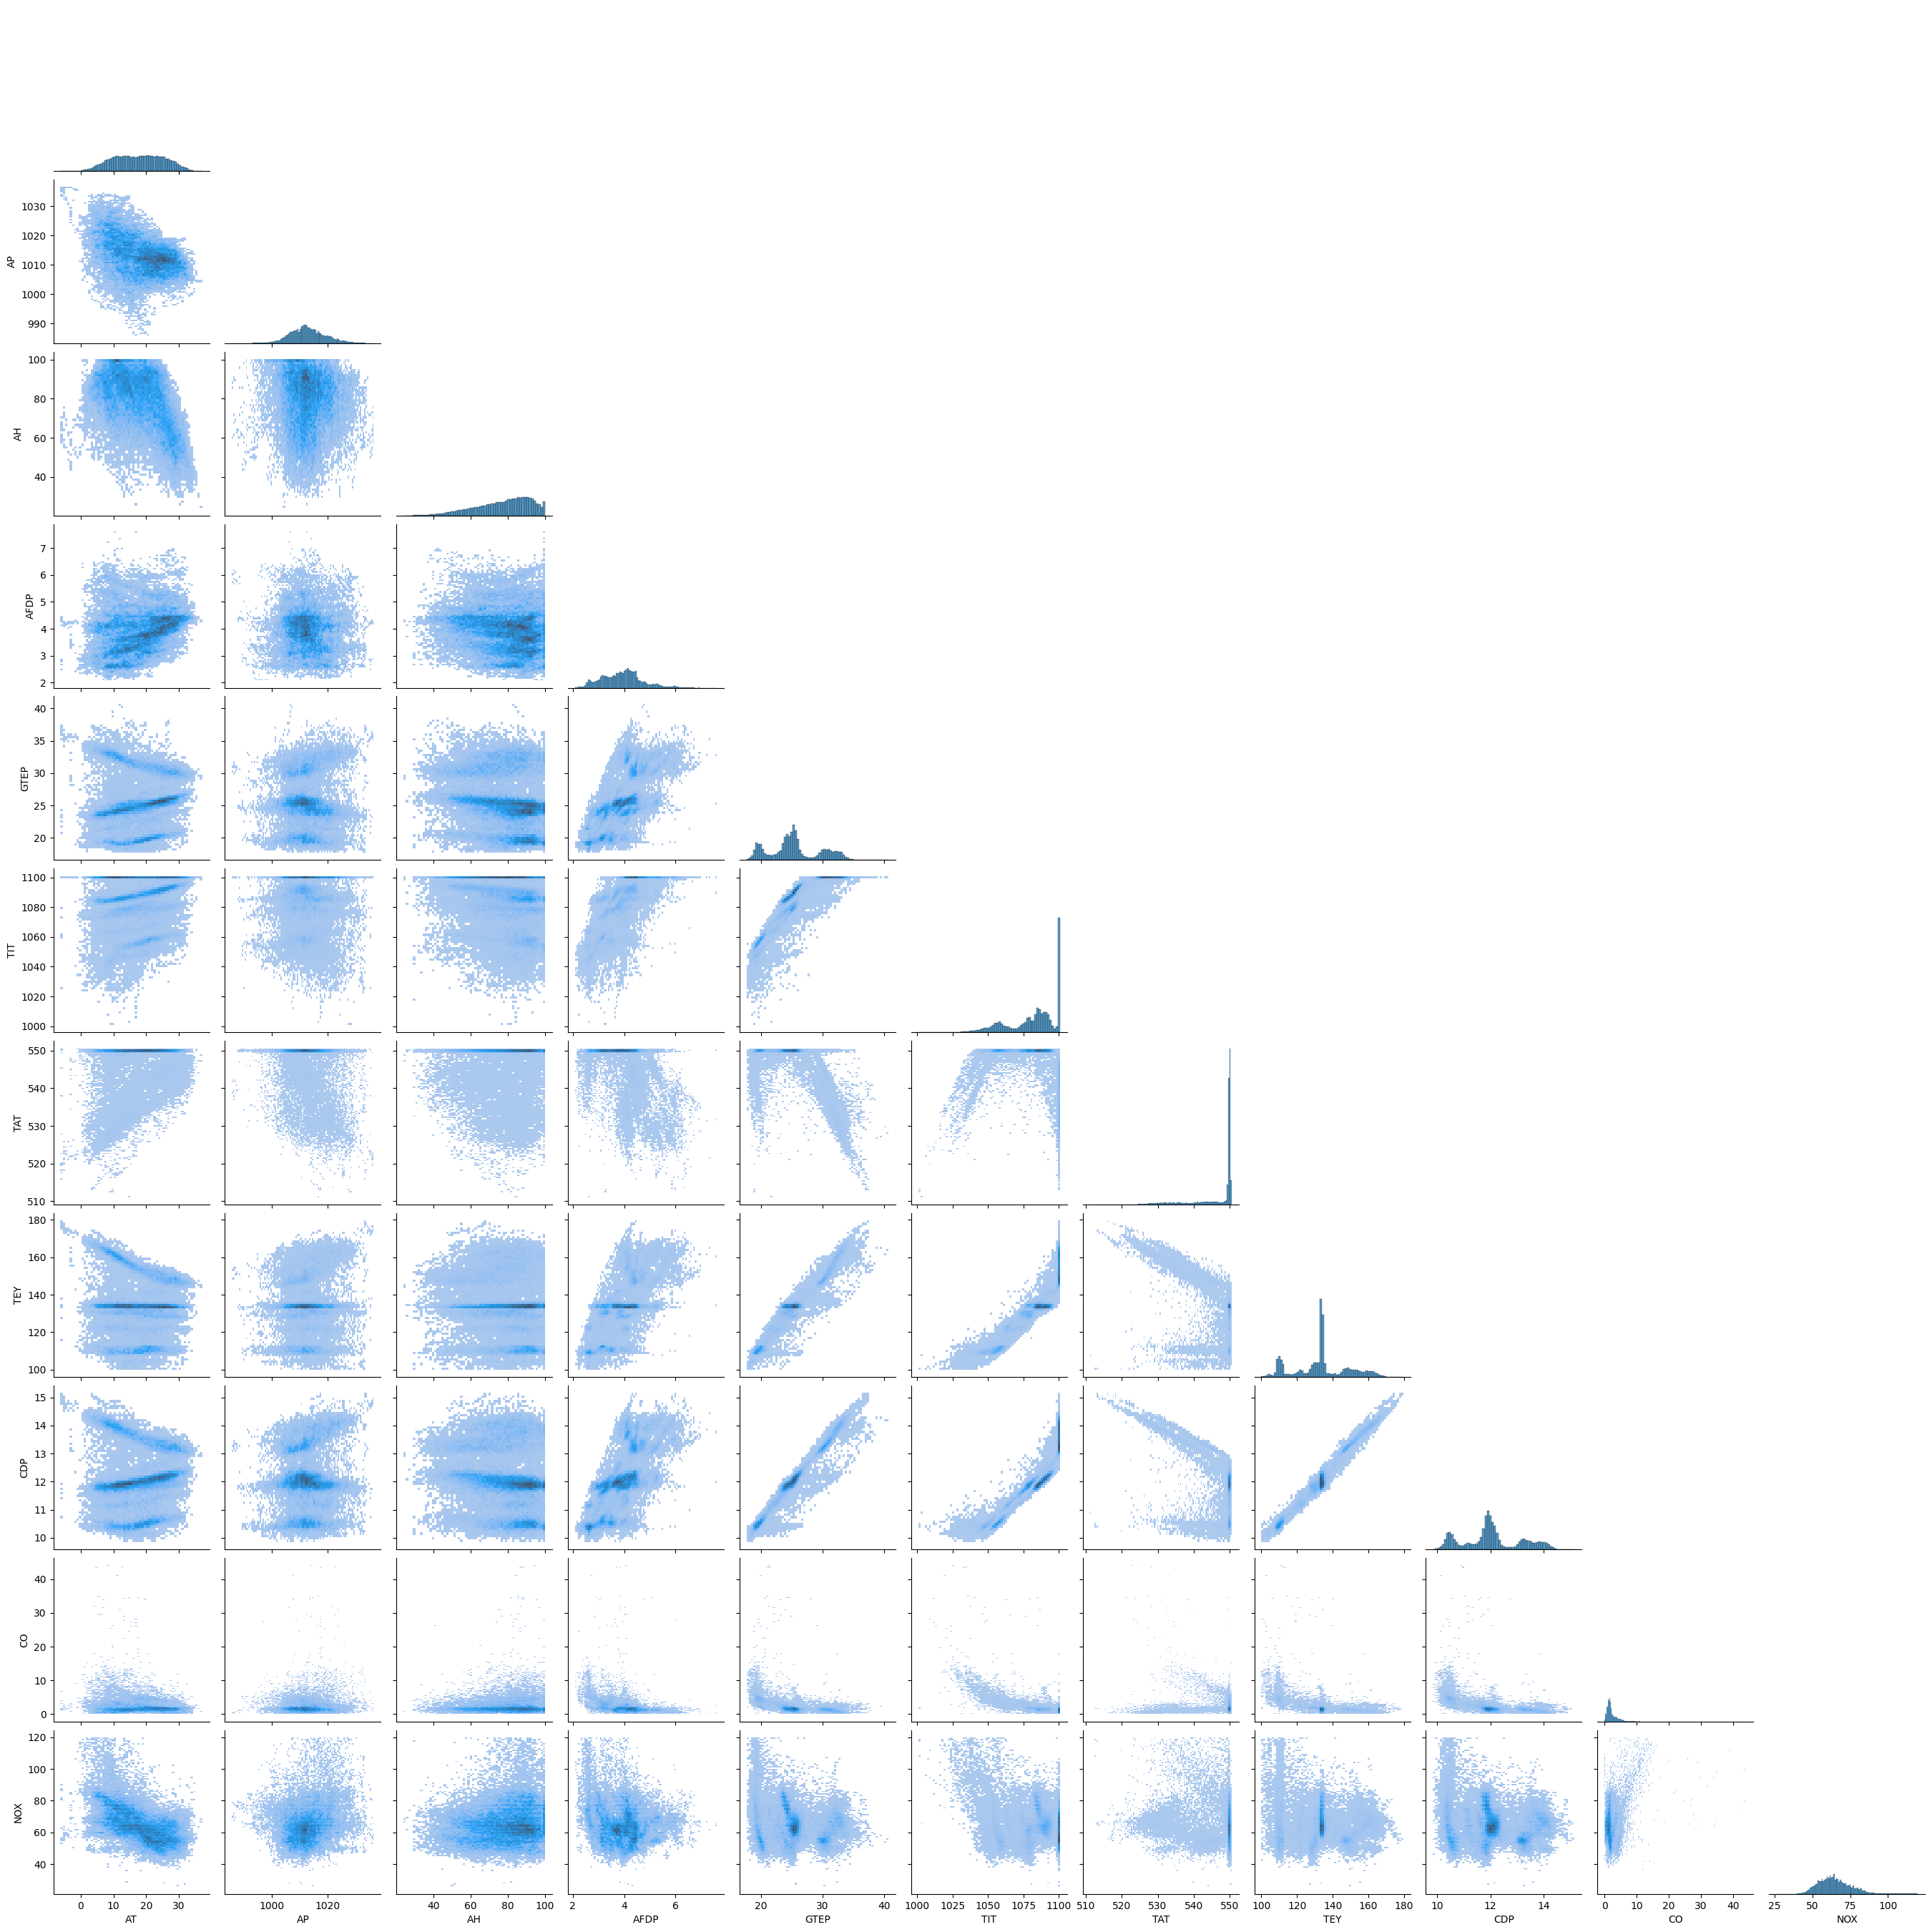

In [61]:
sns.pairplot(turbine_data, corner=True, kind='hist')

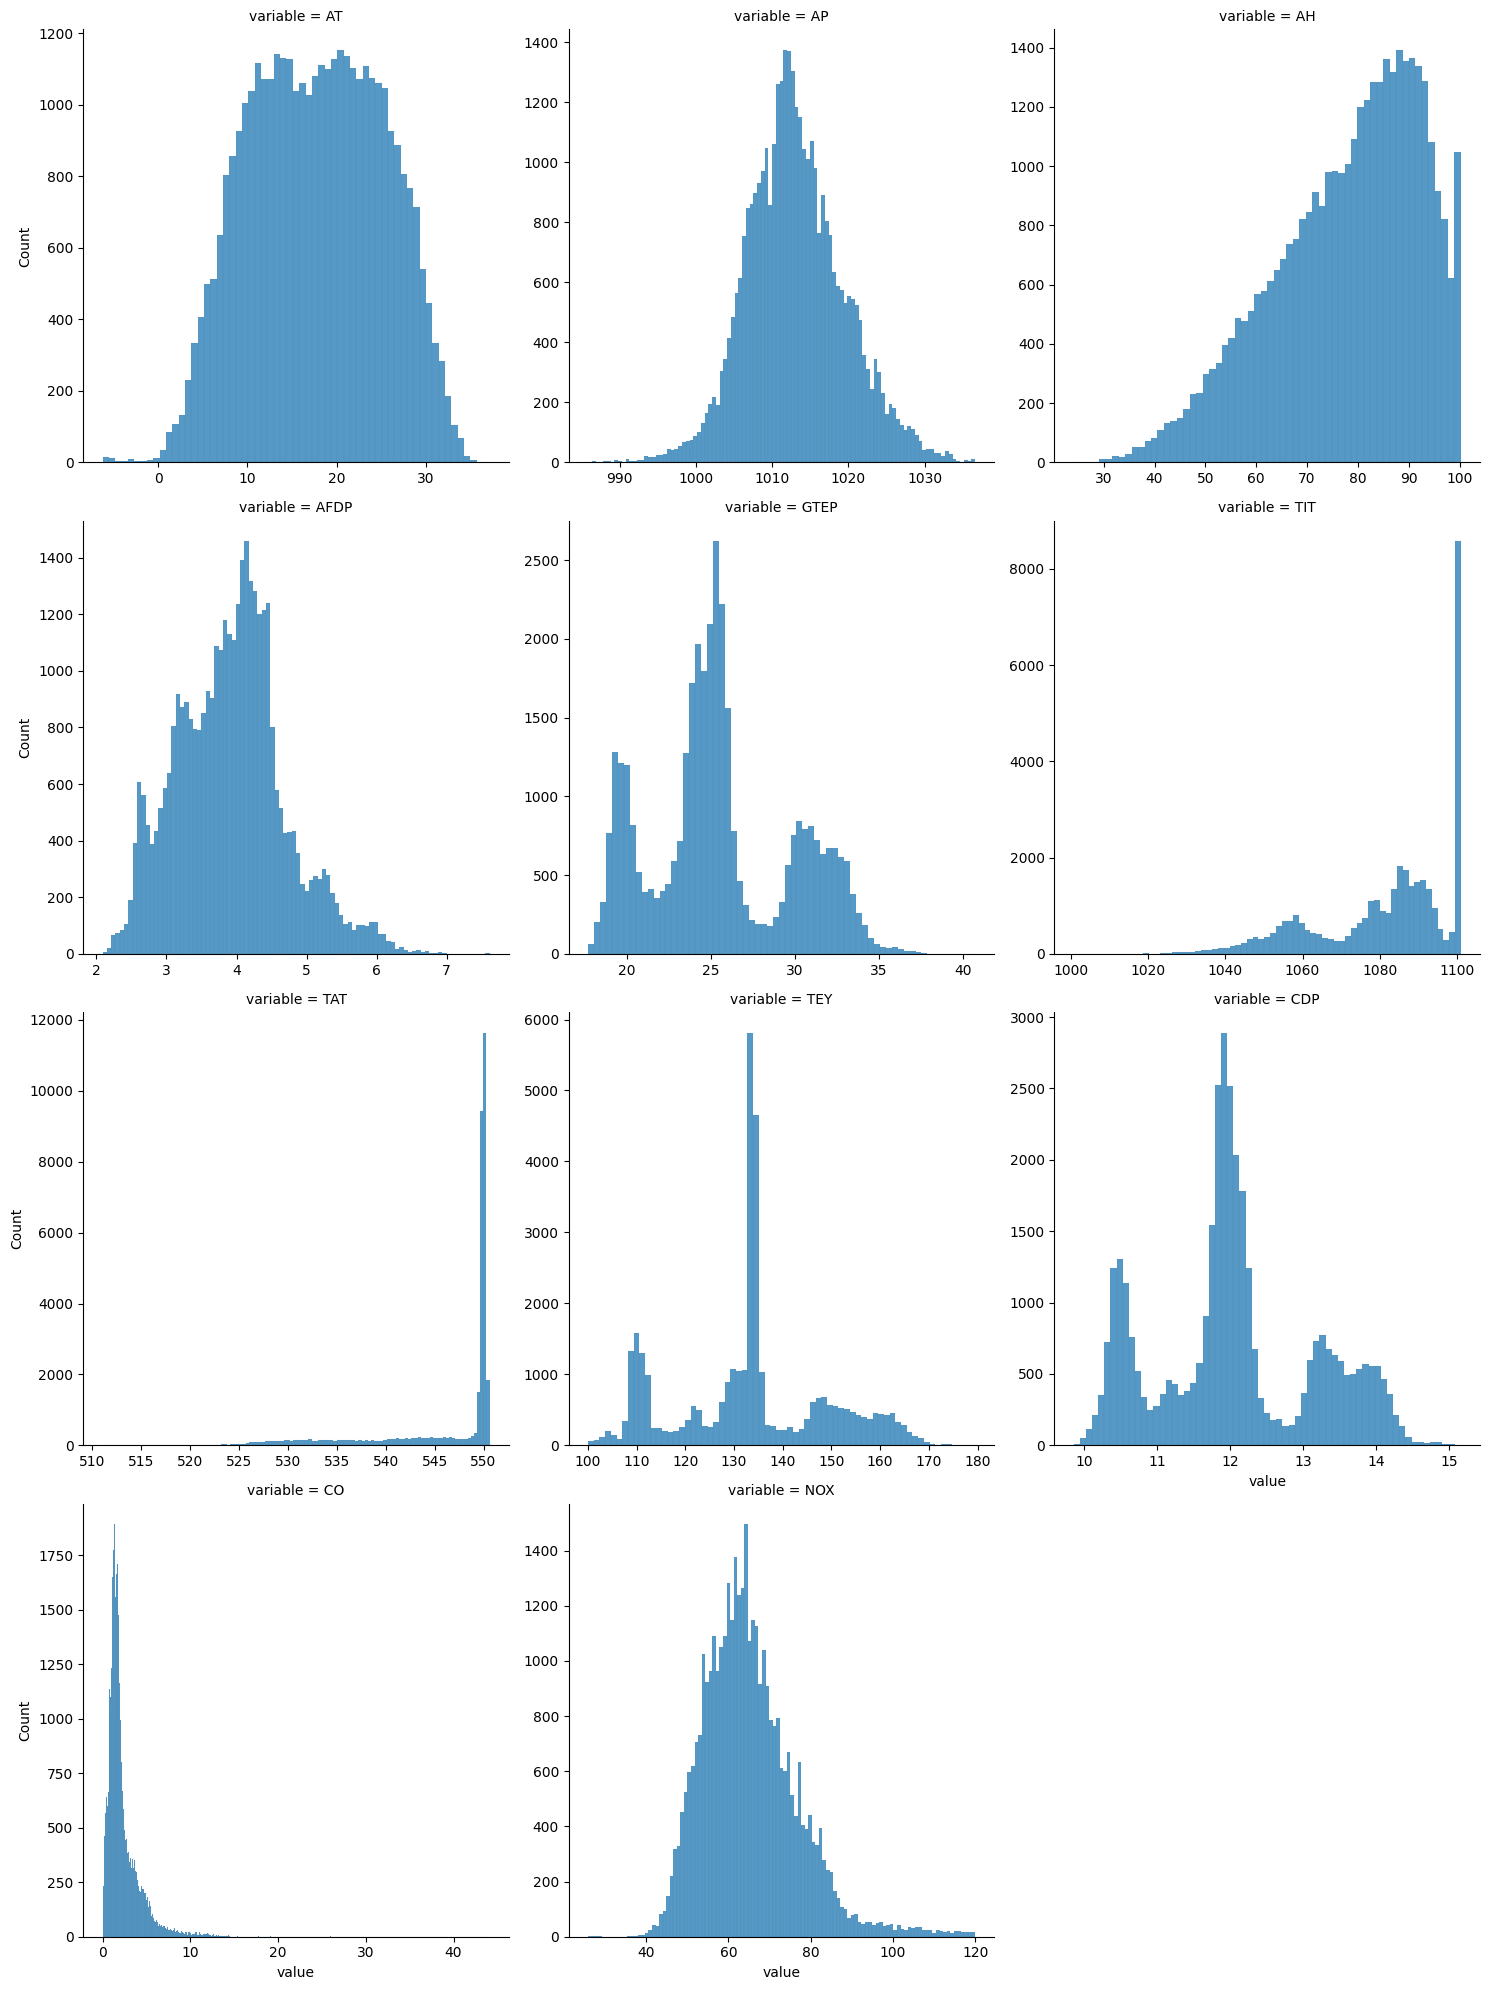

In [62]:
#checking normality

sns.displot(
    x='value',
    data=turbine_data.melt(value_vars=turbine_data),
    col='variable',
    kind='hist',
    col_wrap=3,
    facet_kws={'sharex':False, 'sharey':False},
    common_bins=False
)

The dataset has no null values and not all features are normally distributed. Only temperature and pressure are normally distributed. We have to normalize the dataset before training the model. 

C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


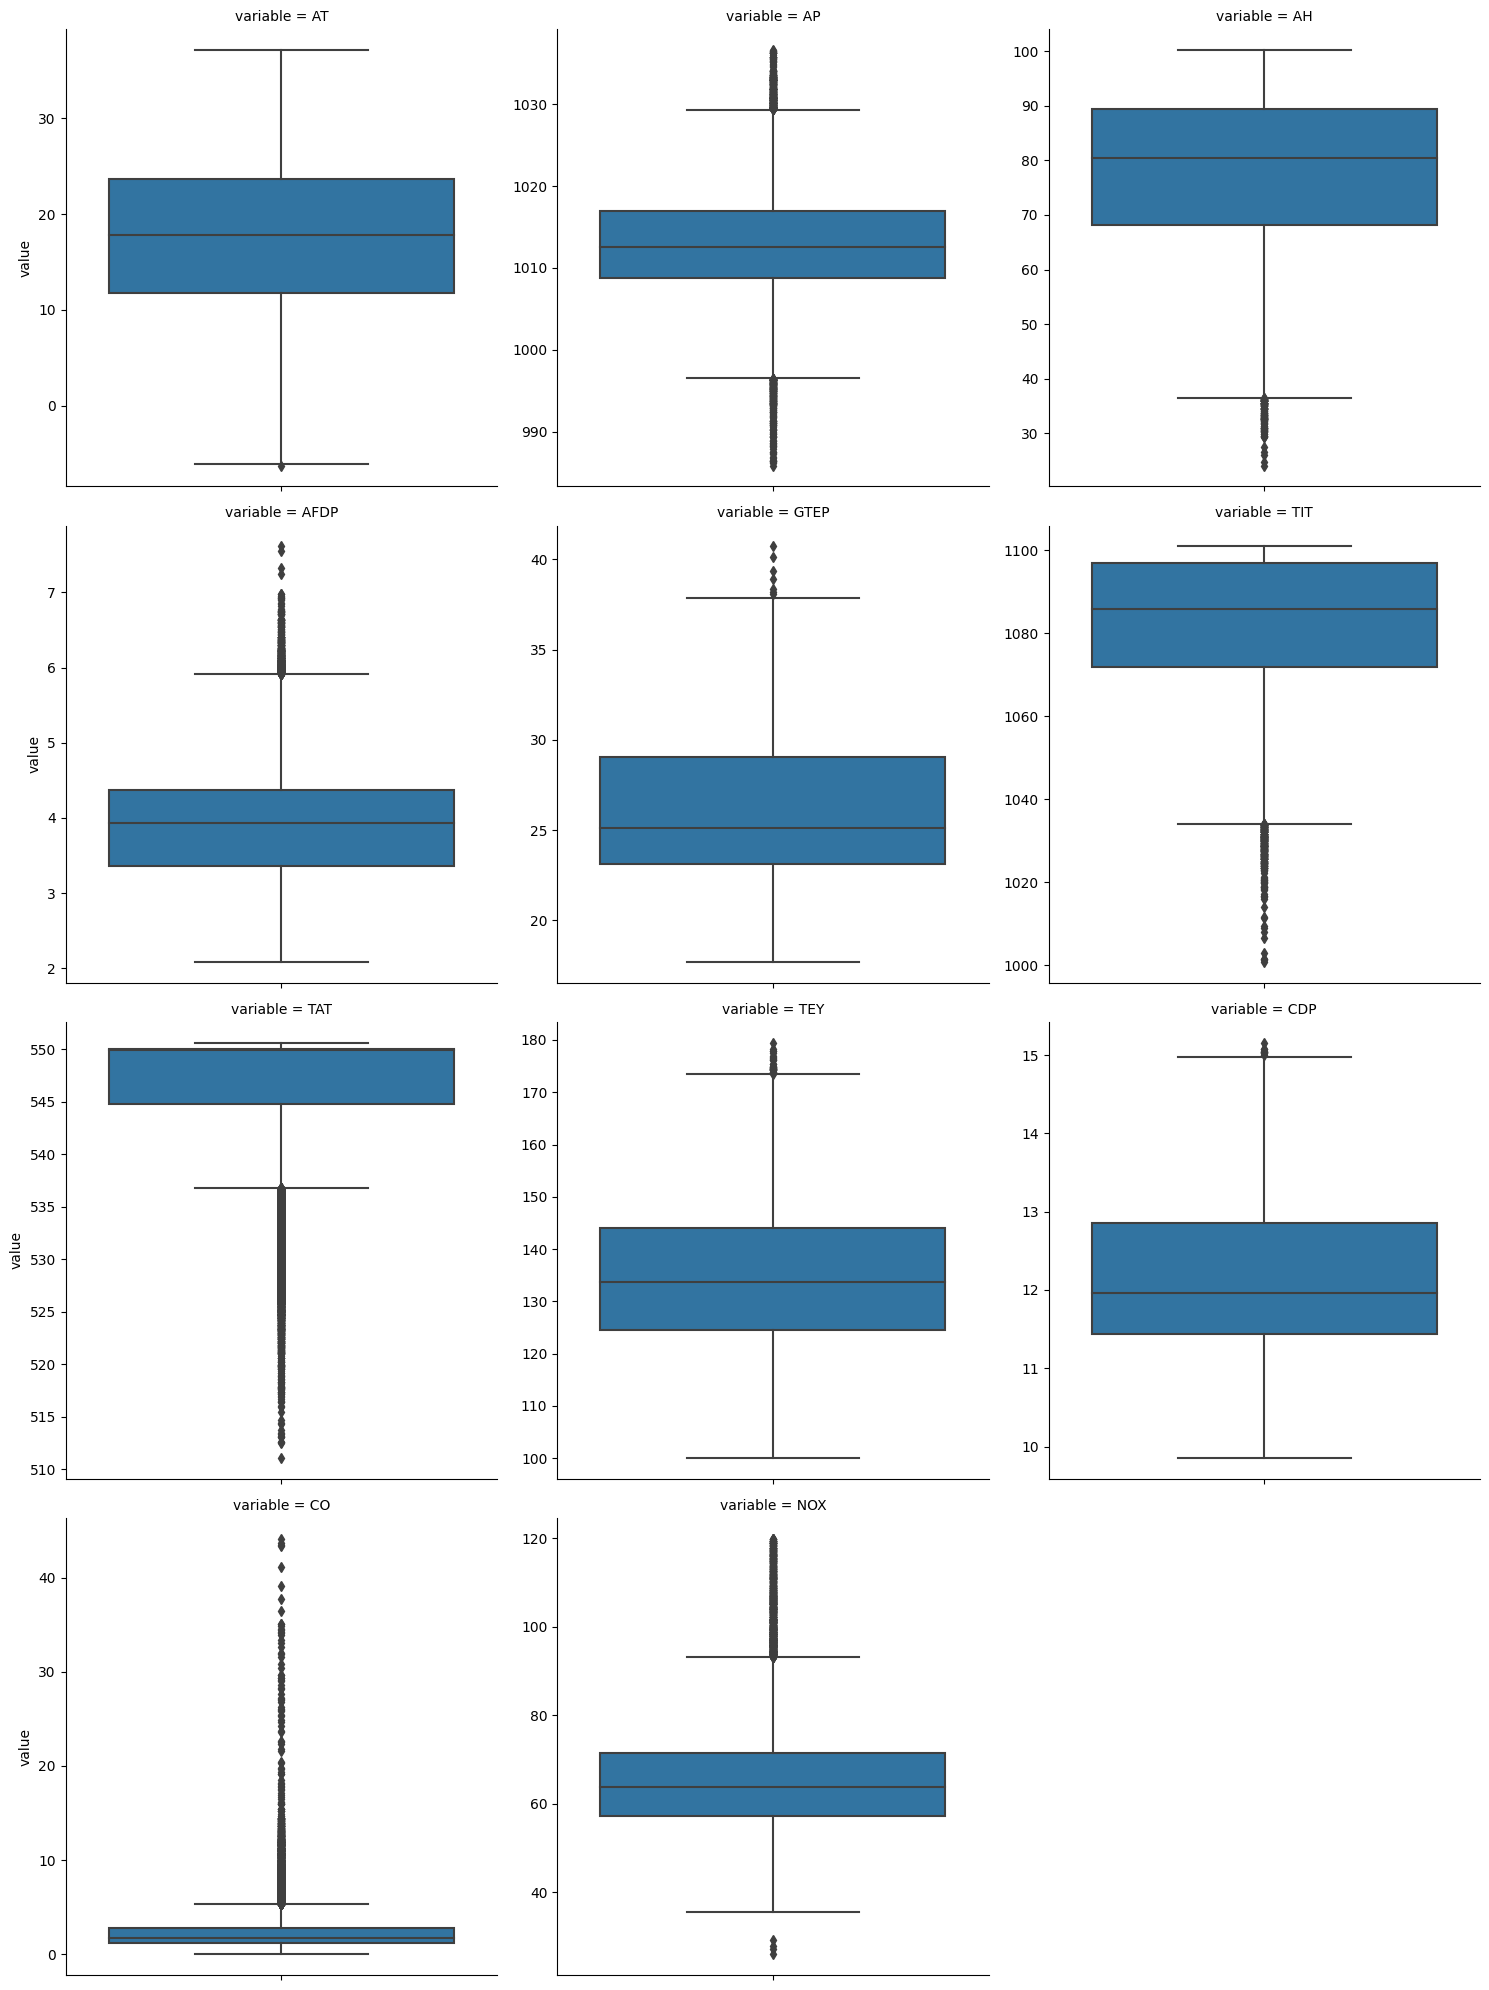

In [63]:
#checking outliers

sns.catplot(
    y='value',
    data=turbine_data.melt(value_vars=turbine_data.columns),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
)

In [64]:
#generating heatmap

cmap = sns.diverging_palette(10,250,as_cmap=True)

def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]),
            dict(selector="td", props=[('padding', "0em 0em")]),
            dict(selector="th:hover", props=[("font-size", "15pt")]),
            dict(selector="tr:hover td:hover", props=[('max-width','300px'),('font-size', '15pt')])
            ]
    
corr = turbine_data.corr()
corr.style.background_gradient(cmap, axis=1)\
.set_properties(**{'max_width':'100px','font-size':'10pt'})\
.set_caption("Hover to magnify")\
.set_precision(2)\
.set_table_styles(magnify())

C:\Users\shari\AppData\Local\Temp\ipykernel_5160\2021506226.py:16: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2)\


The heatmap show the correlation between features and output variable(CO and NOX). Some features are negatively correlated with each other. FOr example, the correlation between TIT and CO is -0.71, this means that if the TIT is reduced the gas turbine will produce more CO. Low TIT reduces the efficiency of gas turbine engines. 

There are two types of parameters: natural and technical. Air pressure, humidity, and temperature are the three that are naturally occurring. The characteristics of how gas turbine plants operate fall under the technical category. We can observe that there is a significant correlation between the technical factors. It makes perfect sense that technical and natural factors have poor correlations.

C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


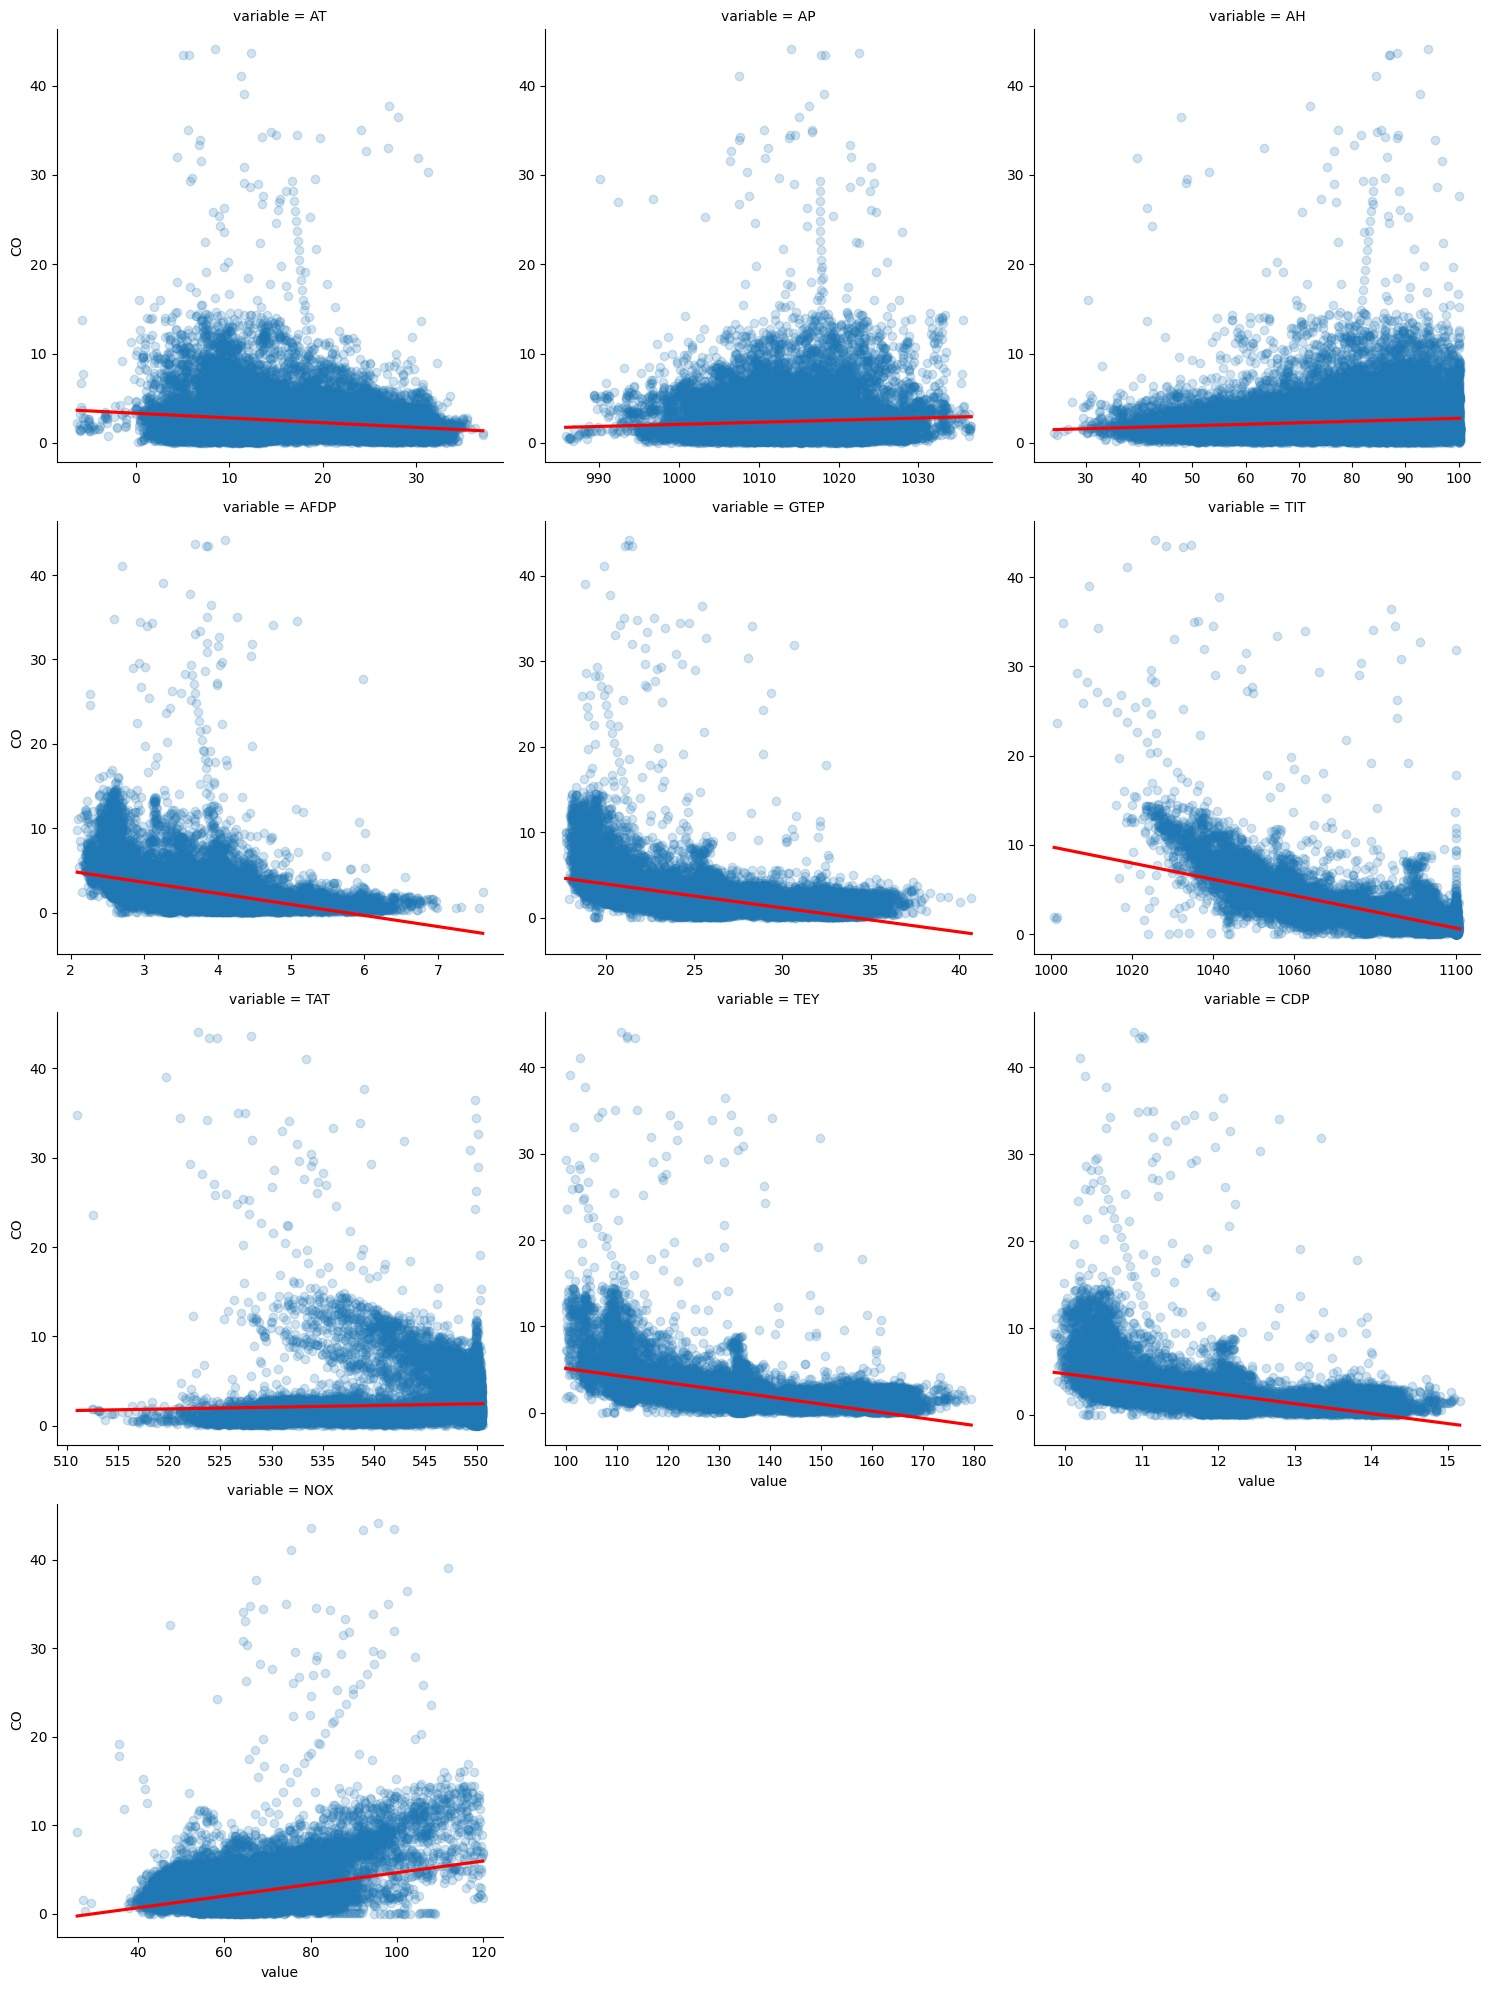

In [65]:
#Analyze each parameter with respect to CO

ax = sns.lmplot(
    x='value',
    y='CO',
    data=turbine_data.melt(id_vars='CO', value_vars=turbine_data),
    col='variable',
    col_wrap=3,
    sharex=False, 
    sharey=False,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2}
)
ax.tight_layout()

There is a good correlation as TEY, CDP and TIT increase, emission of CO decreases. 

C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


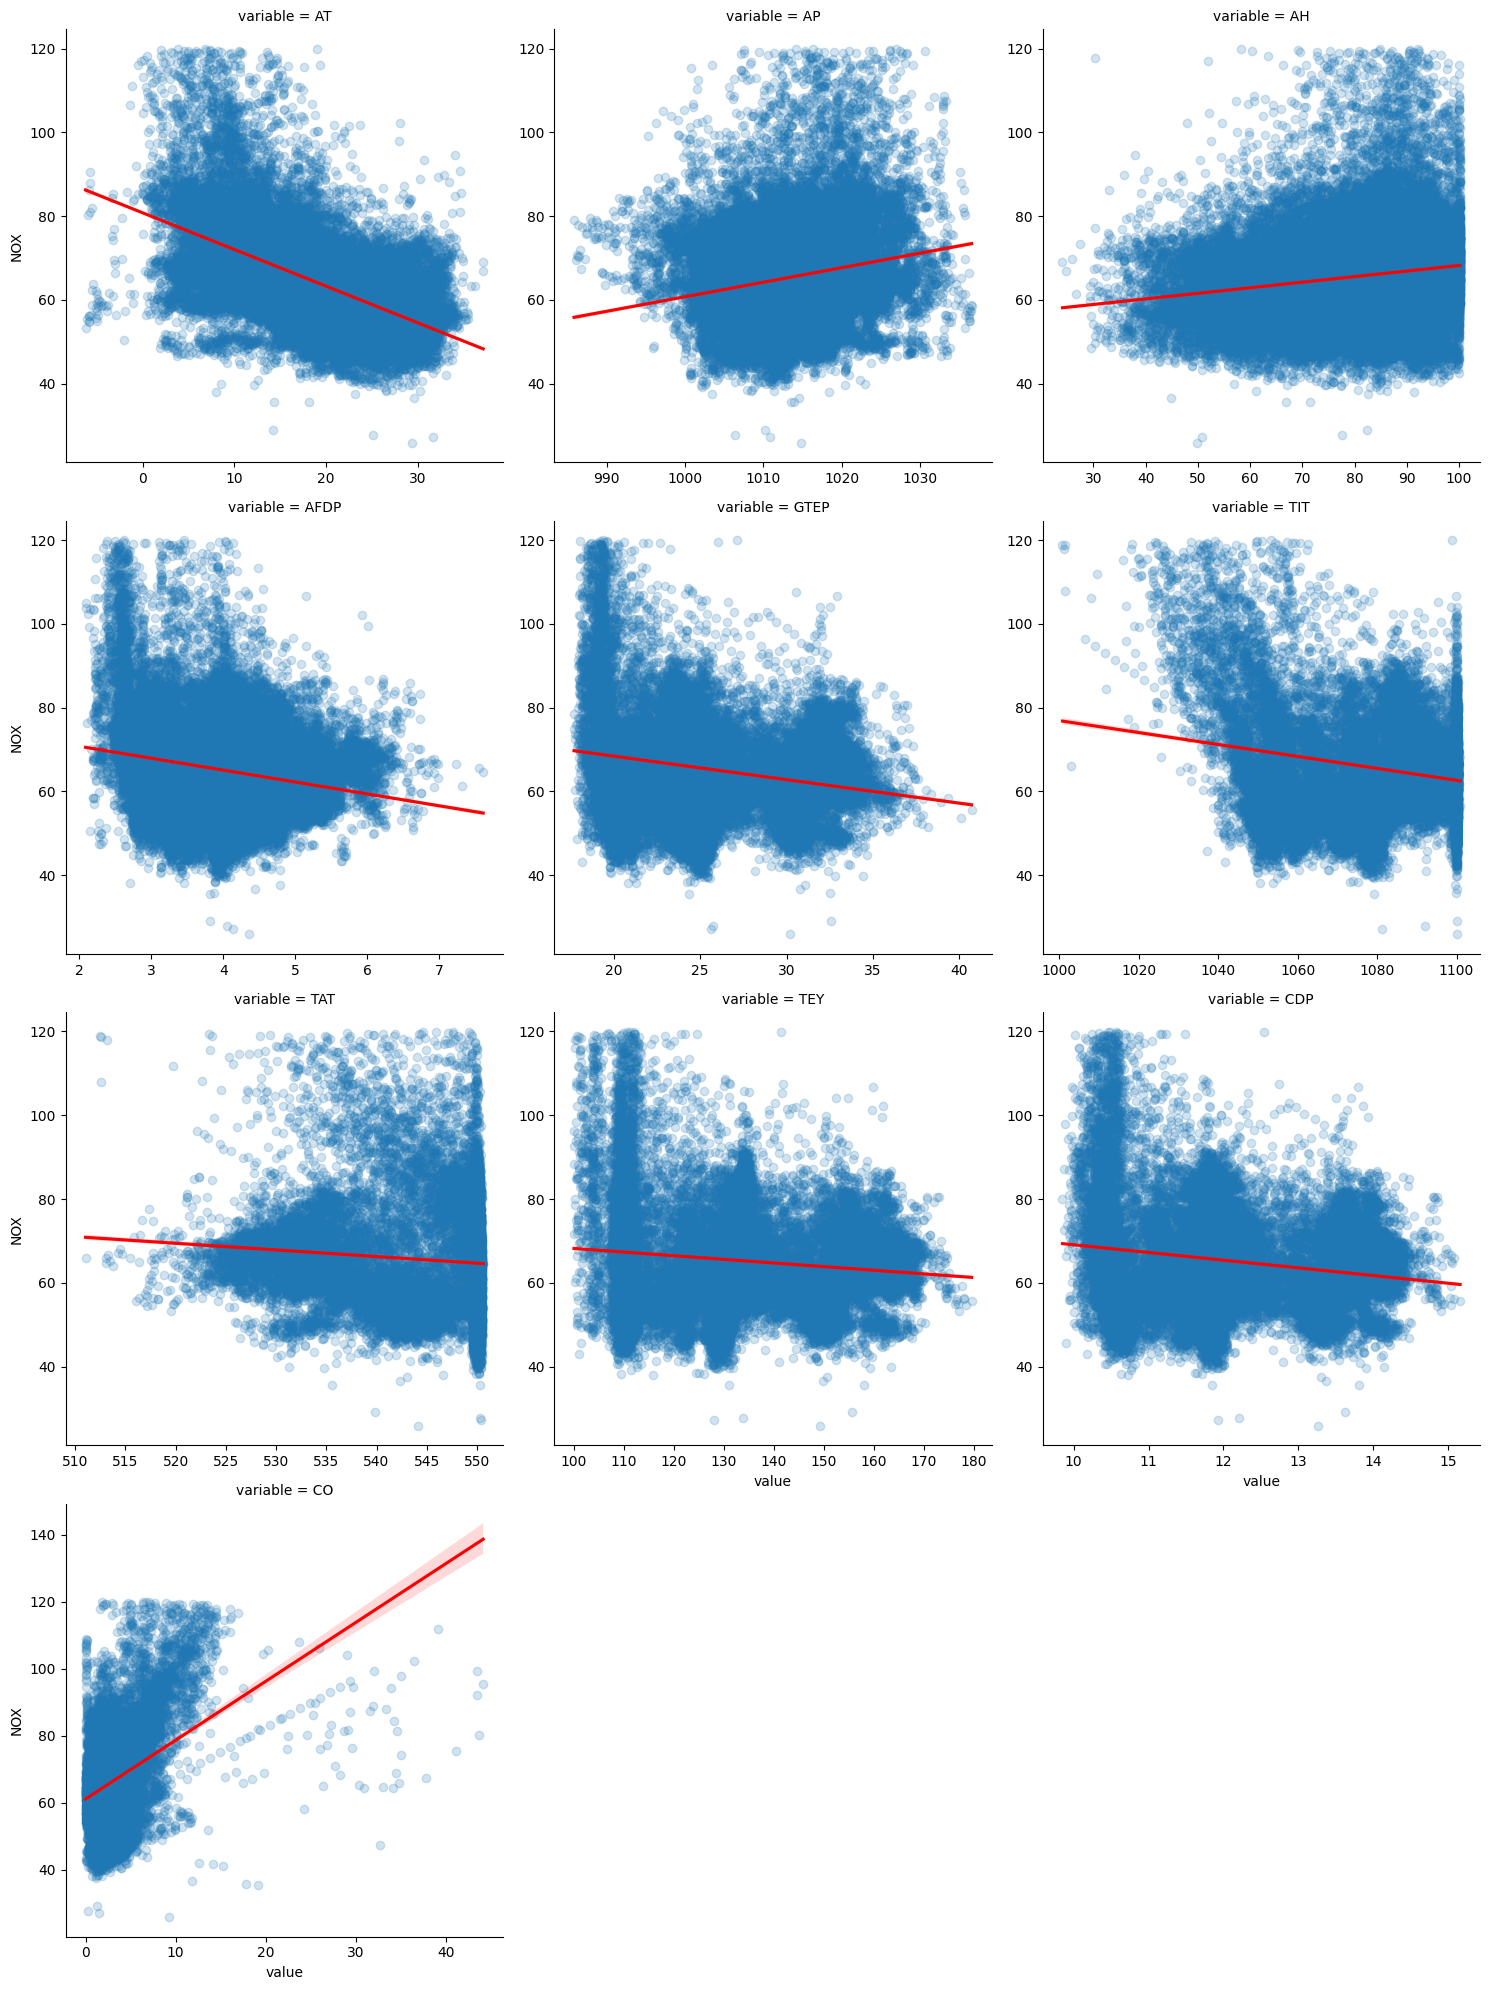

In [66]:
ax = sns.lmplot(
    x='value',
    y='NOX',
    data=turbine_data.melt(id_vars='NOX', value_vars=turbine_data),
    col='variable',
    col_wrap=3,
    sharex=False, 
    sharey=False,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2}
)
ax.tight_layout()

Carbon monoxide and nitrogen oxides has direct correlation. 

## Training a prediction model

In [67]:
turbine_train, turbine_test = train_test_split(turbine_data, test_size=0.2, random_state=42)

X_train = turbine_train.drop(['CO', 'NOX'], axis=1)
y_train = turbine_train[['CO', 'NOX']].copy()


std = StandardScaler()
X_train_std = std.fit_transform(X_train)

In [70]:
lin_reg = LinearRegression()
svc_reg = SVR()
tre_reg = DecisionTreeRegressor(random_state=42)
rnd_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42, verbosity=0)

metrics = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std, y_train[feature], scoring=scorers, n_jobs=-1)
        metrics[reg.__class__.__name__] = {
            **metrics[reg.__class__.__name__], 
            **{
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            }}

In [74]:
def display_metrics(metrics):
    return (pd.DataFrame(metrics).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('Reds'), axis=0))

In [75]:
display_metrics(metrics)

In [79]:
def plot_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.title(f'The importance of features for {model.__class__.__name__}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])

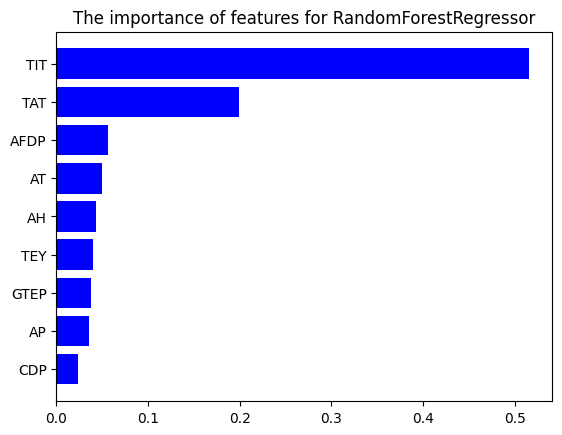

In [80]:
rnd_reg.fit(X_train_std, y_train['CO'])
plot_feature_importance(rnd_reg)

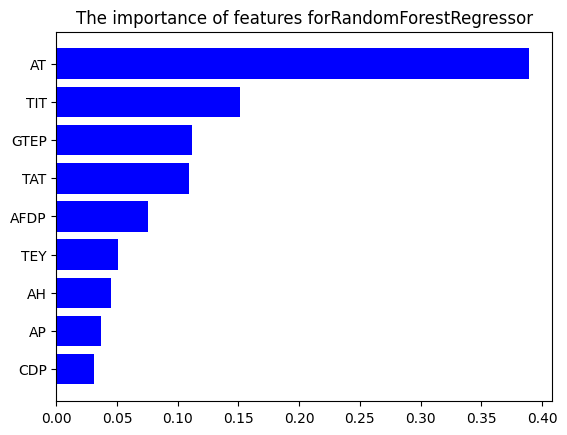

In [78]:
rnd_reg.fit(X_train_std, y_train['NOX'])
plot_feature_importance(rnd_reg)

In [81]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [82]:
boundaries = pd.DataFrame(calculate_iqr_boundaries(X_train))
boundaries

AT       AP          AH      AFDP       GTEP     TIT        TAT  \
0  -5.987   996.65   36.765125  1.814862  14.074125  1033.5  536.67125   
1  41.451  1029.05  120.942125  5.919563  38.101125  1135.1  558.06125   

      TEY        CDP  
0   94.53   9.259375  
1  173.95  15.034375

In [83]:
features_max = [f for f in boundaries.columns if (X_train[f]>boundaries[f].max()).sum()]
features_min = [f for f in boundaries.columns if (X_train[f]<boundaries[f].min()).sum()]

for f in features_max:
    X_train[f][X_train[f] > boundaries[f][1]] = boundaries[f][1]

for f in features_min:
    X_train[f][X_train[f] < boundaries[f][0]] = boundaries[f][0]

C:\Users\shari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


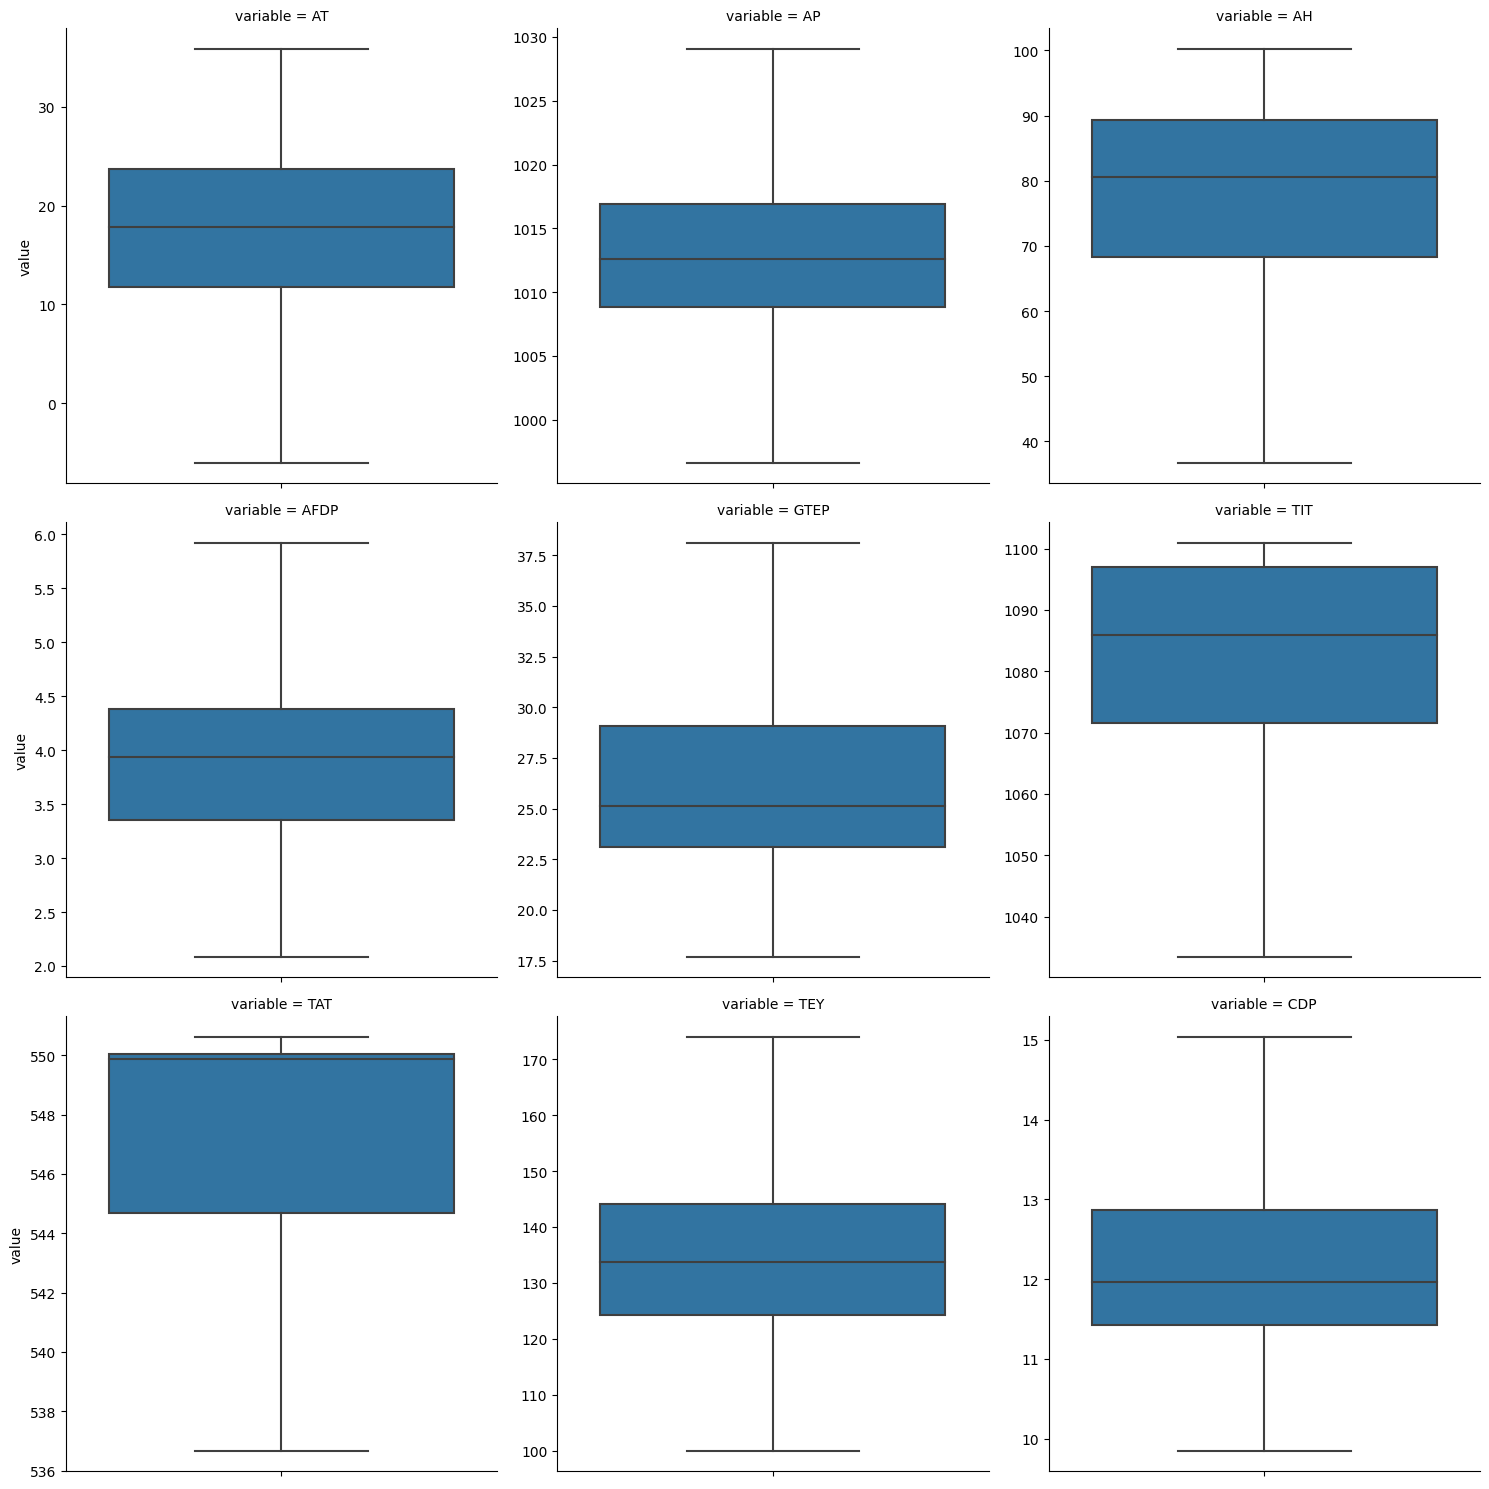

In [84]:
sns.catplot(
    y='value',
    data=X_train.melt(value_vars=X_train.columns),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
)

In [85]:
X_train_std = std.fit_transform(X_train)

metrics1 = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std, y_train[feature], scoring=scorers, n_jobs=-1)
        metrics1[reg.__class__.__name__] = {
            **metrics1[reg.__class__.__name__], 
            **{
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            }}

display_metrics(metrics1)

In [86]:
def diff_metrics(a, b):
    a1 = pd.DataFrame(a).apply(pd.to_numeric)
    b1 = pd.DataFrame(b).apply(pd.to_numeric)
    columns = a.keys()
    index = list(a.values())[0].keys()
    diff = pd.DataFrame((a1.values - b1.values)/b1.values*100, columns=columns, index=index)
    return diff.T.style.format('{:.2f}').background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None, vmin=-10, vmax=10)

diff_metrics(metrics1, metrics)

In [87]:
df_train_std = StandardScaler().fit_transform(turbine_train)
df_train_std = pd.DataFrame(df_train_std, columns=turbine_train.columns, index=turbine_train.index)

db = DBSCAN(eps=1.9, min_samples=40, n_jobs=-1)
db.fit(df_train_std)


unique, counts = np.unique(db.labels_, return_counts=True)
np.c_[unique, counts]

array([[   -1,   138],
       [    0, 29248]], dtype=int64)

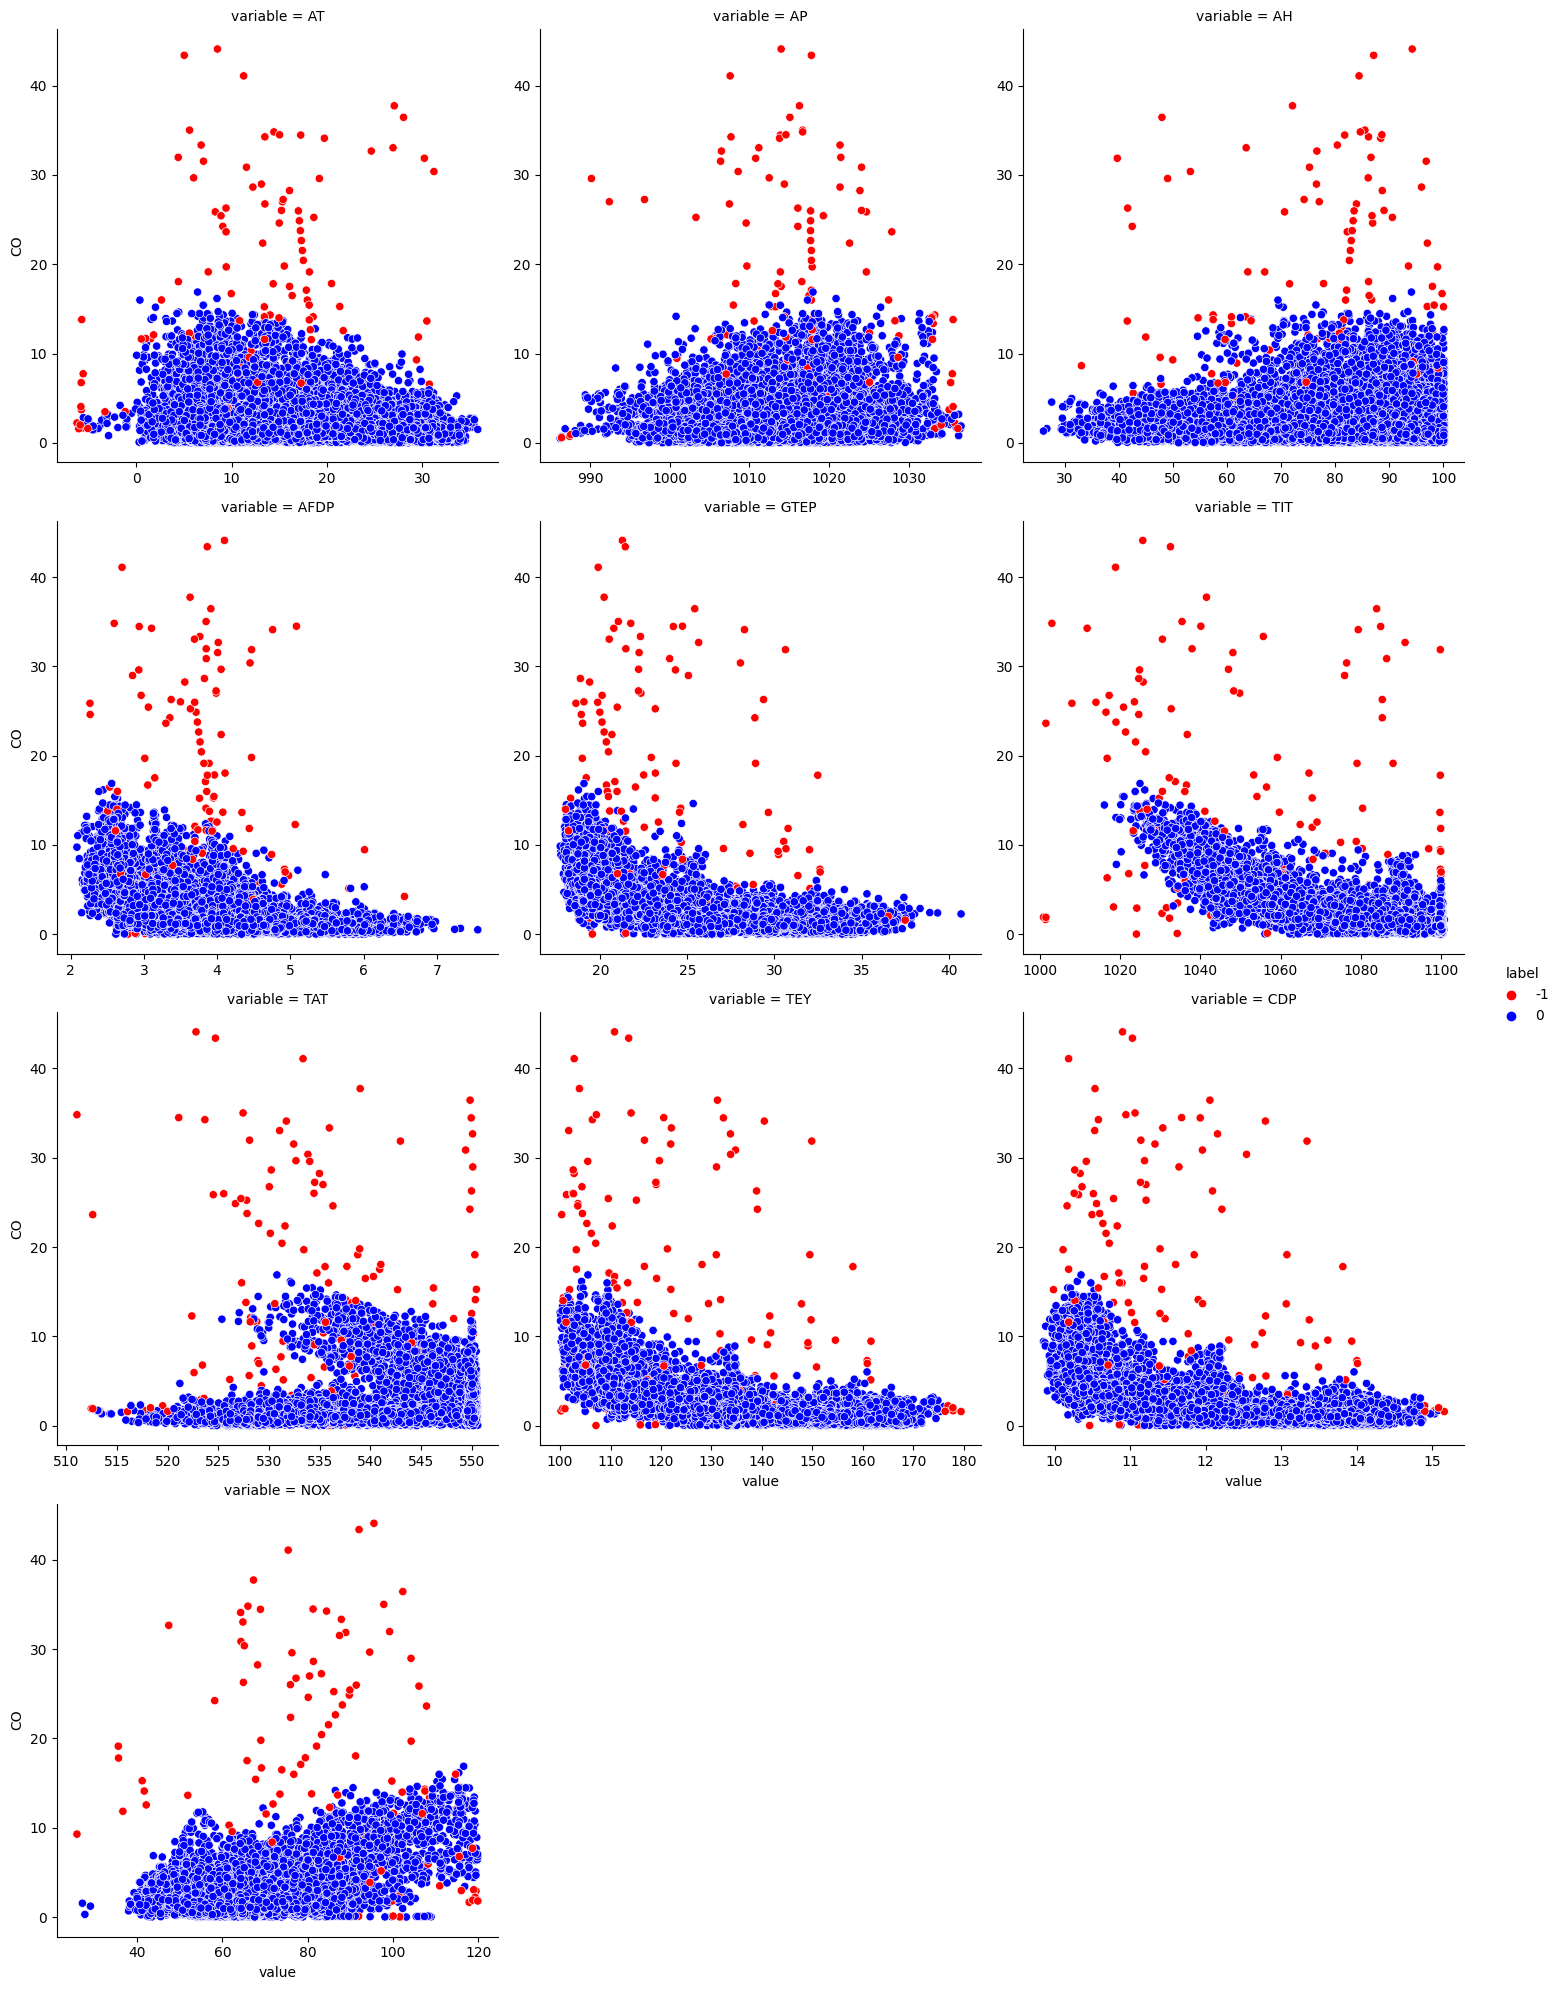

In [89]:
df_db = turbine_train.copy()
df_db['label'] = db.labels_

ax = sns.relplot(
    x='value',
    y='CO',
    data=df_db.melt(id_vars=['CO', 'label'], value_vars=df_db),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout()

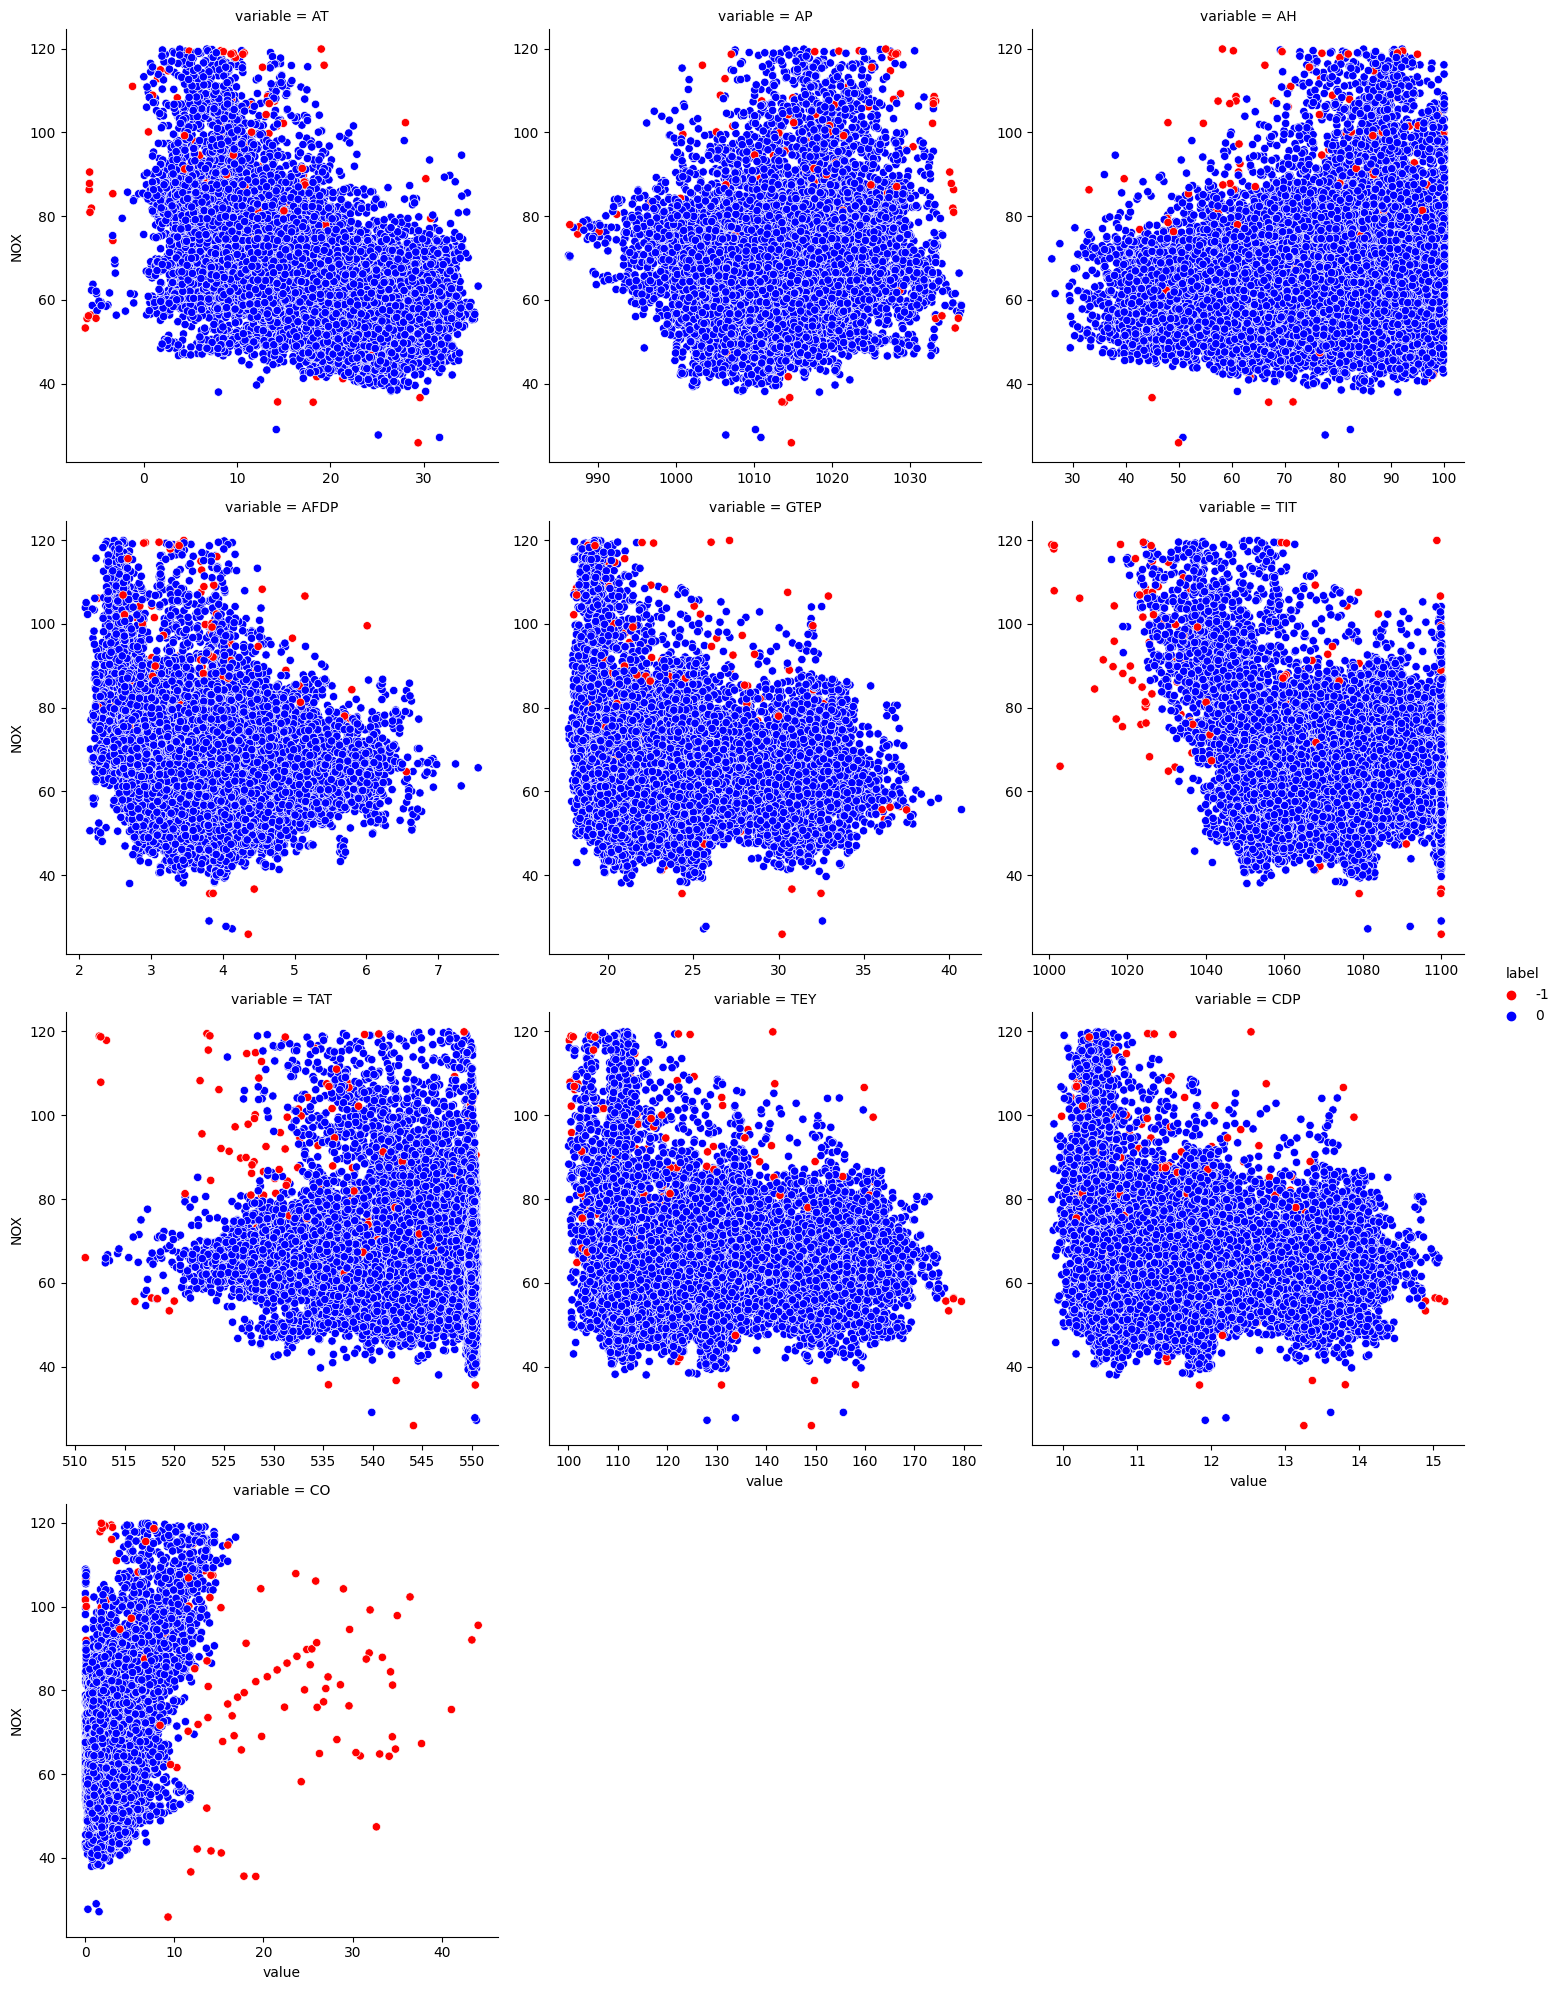

In [90]:
ax = sns.relplot(
    x='value',
    y='NOX',
    data=df_db.melt(id_vars=['NOX', 'label'], value_vars=df_db),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout();

In [91]:
idx = db.core_sample_indices_


X_train = turbine_train.drop(['CO', 'NOX'], axis=1)
y_train = turbine_train[['CO', 'NOX']].copy()

X_test = turbine_test.drop(['CO', 'NOX'], axis=1)
y_test = turbine_test[['CO', 'NOX']].copy()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

metrics2 = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std[idx], y_train[feature].iloc[idx], scoring=scorers, n_jobs=-1)
        metrics2[reg.__class__.__name__] = {
            **metrics2[reg.__class__.__name__], 
            **{
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            }}
        
display_metrics(metrics2)

In [92]:
diff_metrics(metrics2, metrics)

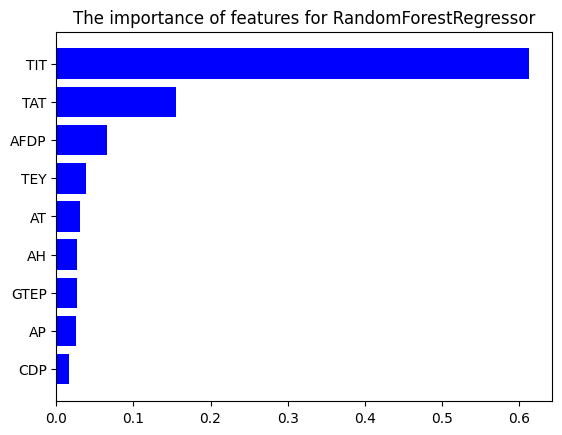

In [93]:
rnd_reg.fit(X_train_std[idx], y_train['CO'].iloc[idx])
plot_feature_importance(rnd_reg)

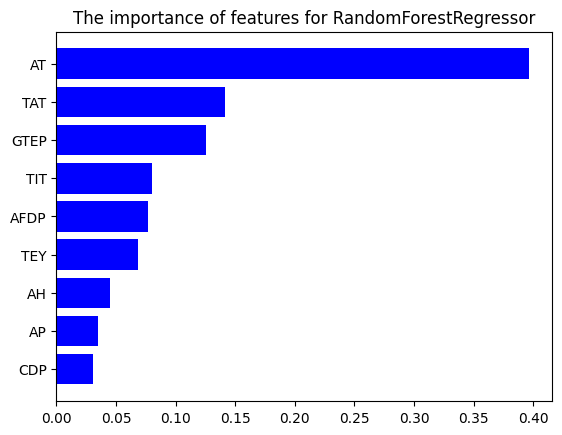

In [95]:
rnd_reg.fit(X_train_std[idx], y_train['NOX'].iloc[idx])
plot_feature_importance(rnd_reg)

In [96]:
labels = db.labels_ + 1

knn = KNeighborsClassifier()

param_grid = {'n_neighbors' : np.arange(2, 50)}
knn_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5)
knn_search.fit(X_train_std, labels)


print(f'n_neighbors = {knn_search.best_params_["n_neighbors"]}')
print(f'best_score = {knn_search.best_score_:.3f}')

n_neighbors = 3
best_score = 0.997


In [97]:
knn = knn_search.best_estimator_
knn.fit(X_train_std, labels)

y_pred = knn.predict(X_test_std)

unique, counts = np.unique(y_pred, return_counts=True)
np.c_[unique, counts]

array([[   0,   27],
       [   1, 7320]], dtype=int64)

(array([ 31., 142., 340., 565., 711., 736., 782., 630., 547., 475., 376.,
        333., 253., 215., 177., 148., 140.,  97., 112.,  82.,  66.,  47.,
         39.,  34.,  39.,  24.,  25.,  20.,  24.,  28.,  11.,  14.,  10.,
         10.,   9.,  10.,   4.,   8.,   5.,   5.,   3.,   3.,   0.,   2.,
          0.,   0.,   0.,   0.,   1.,   2.,   1.,   1.,   0.,   1.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.02392991, 0.04762568, 0.07132146, 0.09501724, 0.11871302,
        0.14240879, 0.16610457, 0.18980035, 0.21349613, 0.2371919 ,
        0.26088768, 0.28458346, 0.30827924, 0.33197501, 0.35567079,
        0.37936657, 0.40306235, 0.42675812, 0.4504539 , 0.47414968,
        0.49784546, 0.52154123, 0.54523701, 0.

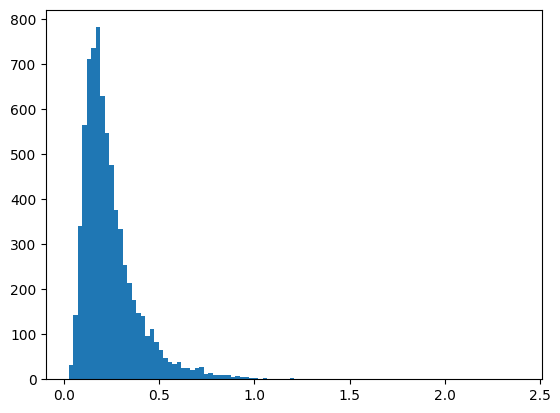

In [98]:
y_dist, _  = knn.kneighbors(X_test_std, n_neighbors=1)
plt.hist(y_dist, bins=100)

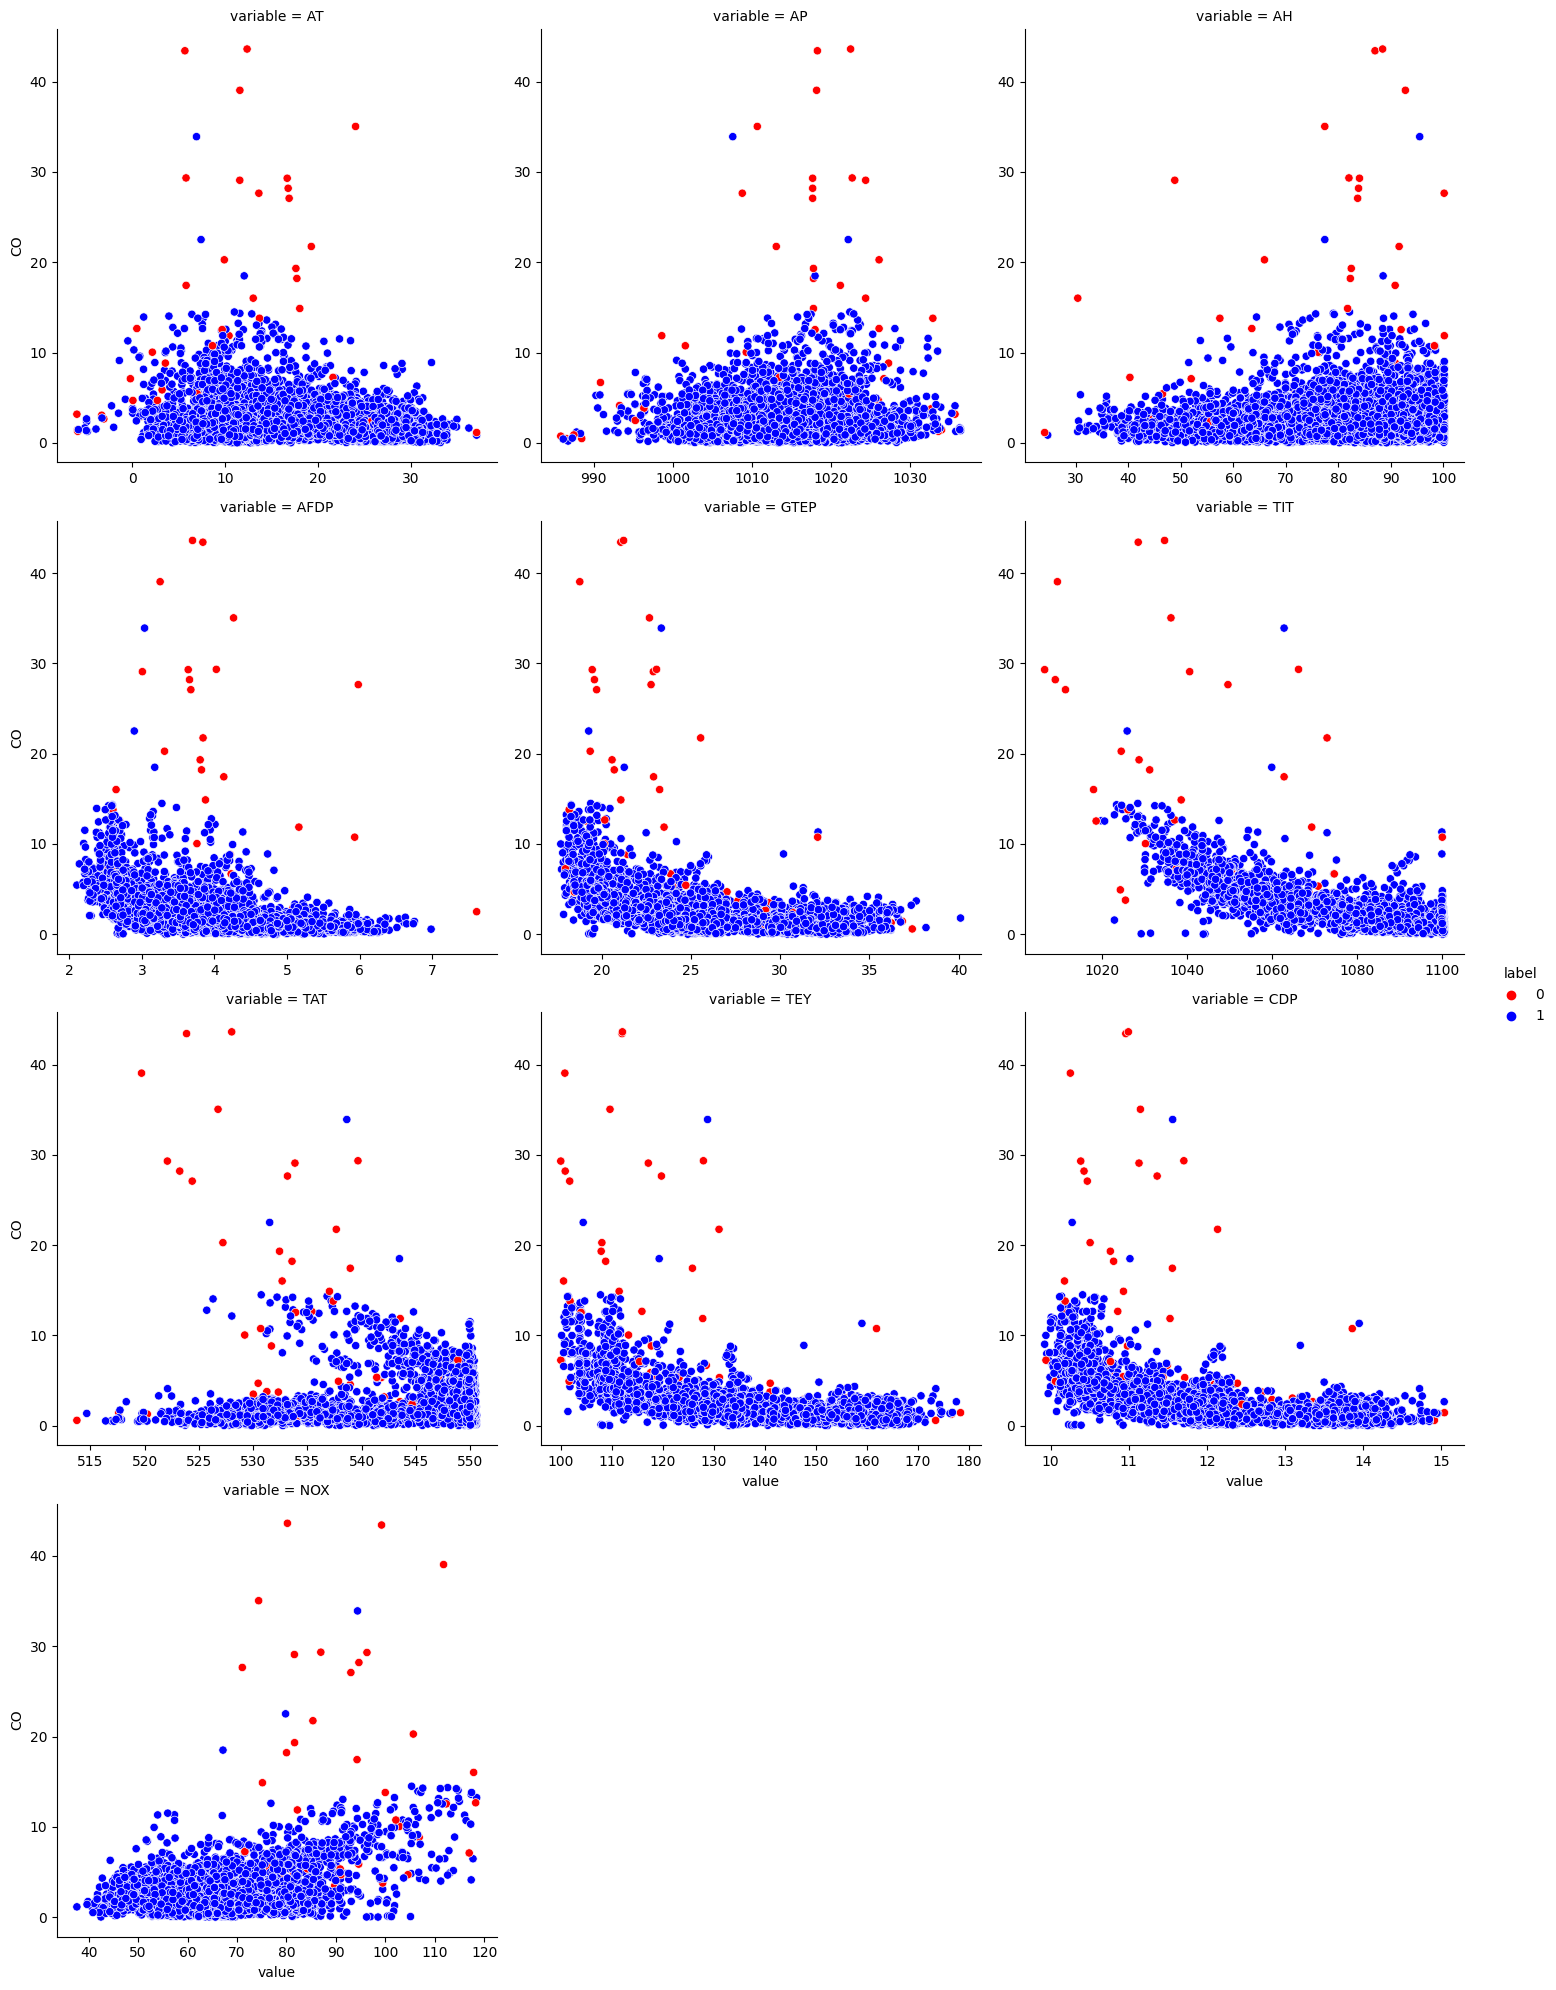

In [100]:
y_pred[y_dist.ravel()>0.9] = 0

df_db_test = turbine_test.copy()
df_db_test['label'] = y_pred

ax = sns.relplot(
    x='value',
    y='CO',
    data=df_db_test.melt(id_vars=['CO', 'label'], value_vars=df_db_test),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout()

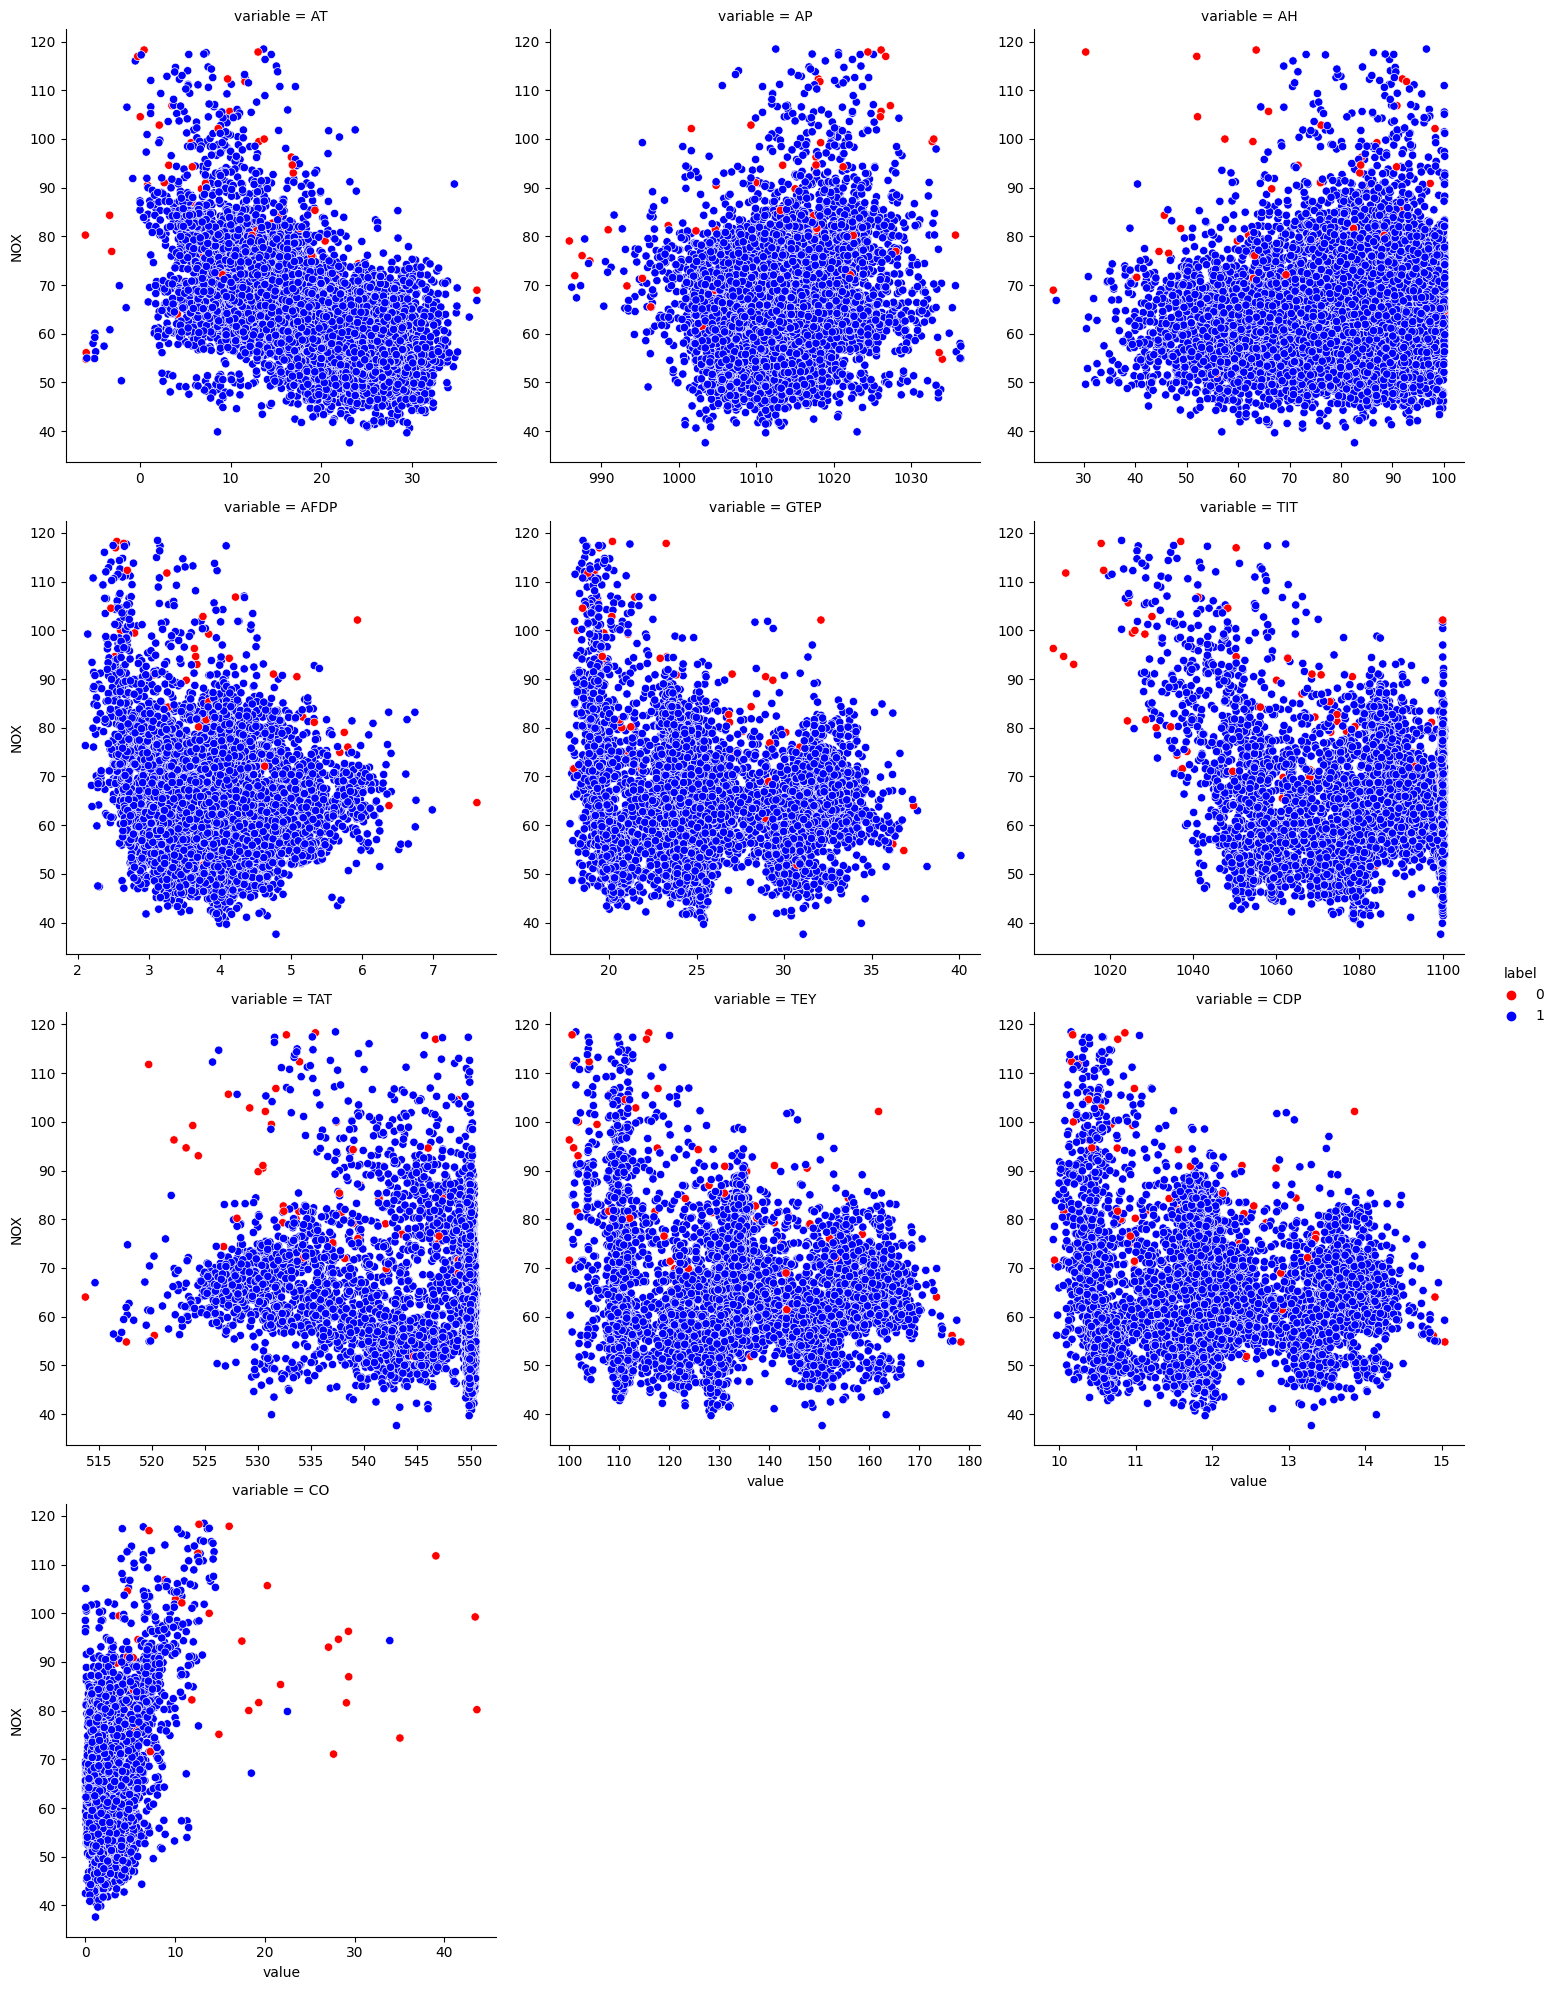

In [101]:
ax = sns.relplot(
    x='value',
    y='NOX',
    data=df_db_test.melt(id_vars=['NOX', 'label'], value_vars=df_db_test),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout()

In [102]:
idxs = np.where(y_pred>0)[0]

metrics3 = defaultdict(dict)
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        reg.fit(X_train_std[idx], y_train[feature].iloc[idx])
        metrics3[reg.__class__.__name__] = {
            **metrics3[reg.__class__.__name__], 
            **{
                f'{feature}_rmse': mean_squared_error(y_test[feature].iloc[idxs], reg.predict(X_test_std[idxs]), squared=False),
                f'{feature}_mae': mean_absolute_error(y_test[feature].iloc[idxs], reg.predict(X_test_std[idxs]))
            }}
        
display_metrics(metrics3)

The best result was shown by Random Forest. XGBRegressor performed slightly worse. Perhaps if we search for optimal hyperparameters, XGBRegressor will show the best accuracy. The values of RMSE and MSE on the test sample are almost the same as on the training sample. 